In [2]:
import os
import seisbench
import seisbench.data as sbd
import seisbench.models as sbm
import seisbench.generate as sbg
from seisbench.util import worker_seeding
from seisbench.models import SeisBenchModel 

import torch
from torch.utils.data import DataLoader
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from obspy.clients.fdsn import Client
from obspy import UTCDateTime

# Aqui hay 4 clases

In [3]:
data = sbd.TXED(cache="full",sampling_rate=100) #Esta accion es recomendable hacerla en terminal pues tarda mucho
                                #cambiar a "full" una vez que este completo el codigo
#data = sbd.DummyDataset(sampling_rate=50)  #sampling_rate=100
data.preload_waveforms(pbar=True) #importante, pbar==progressbar
print(data)

2024-09-08 17:40:49,493 | seisbench | WARNING | Output component order not specified, defaulting to 'ZNE'.
Preloading waveforms:   0%|          | 0/1046 [00:00<?, ?it/s]

Preloading waveforms: 100%|██████████| 1046/1046 [00:05<00:00, 178.71it/s]

TXED - 1046 traces


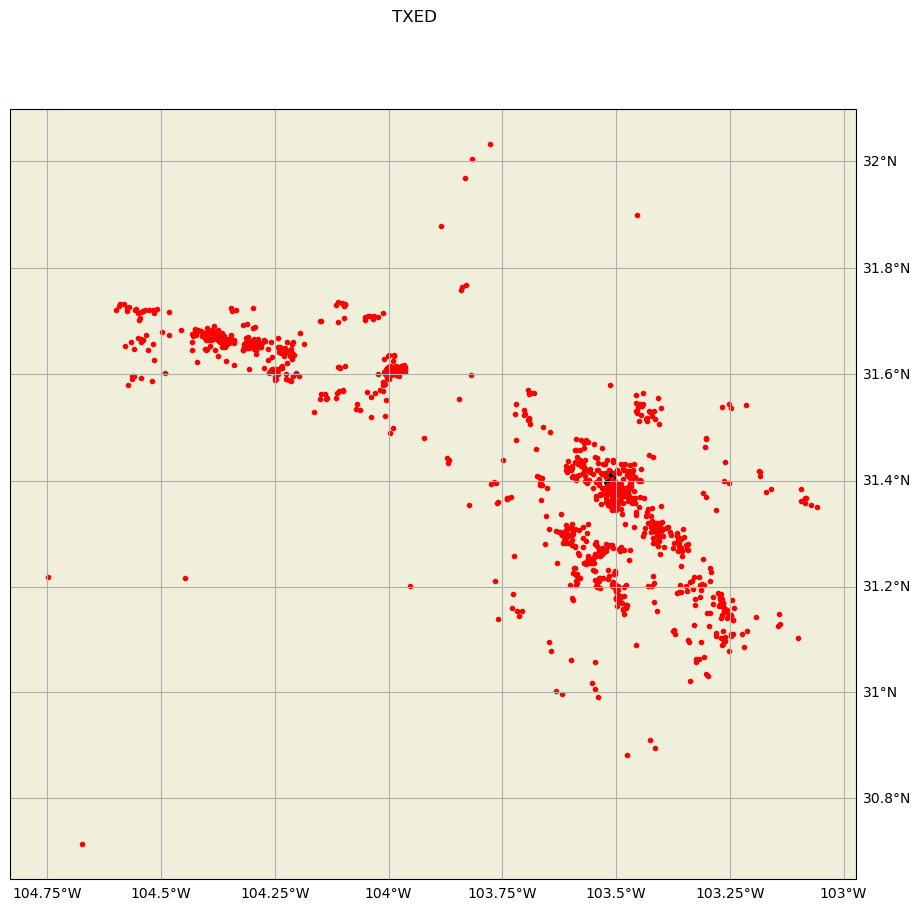

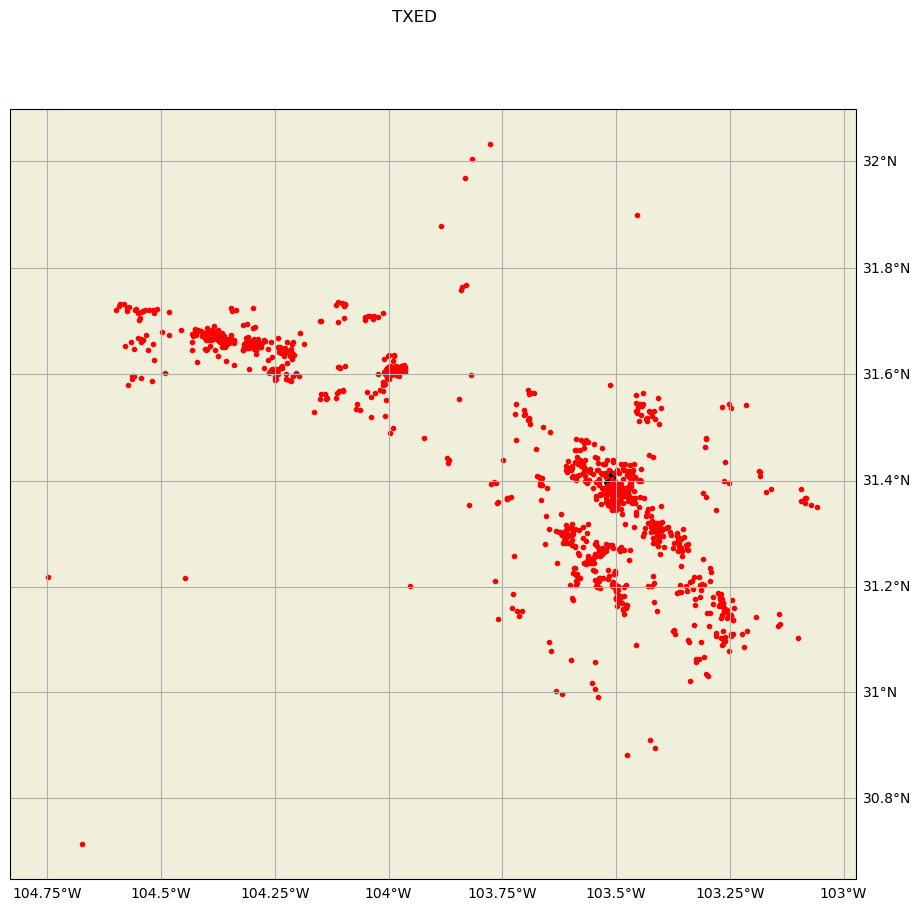

In [4]:
data.plot_map()

In [5]:
train = data.train()
dev = data.dev()

In [6]:
print(len(train))
print(len(dev))

976
70


In [7]:
train_generator = sbg.GenericGenerator(train)
dev_generator = sbg.GenericGenerator(dev)

In [8]:
#train_generator.augmentation(sbg.Normalize(detrend_axis=-1, amp_norm_axis=-1))
#dev_generator.augmentation(sbg.Normalize(detrend_axis=-1, amp_norm_axis=-1))

In [9]:
phase_dict = {
    "trace_p_arrival_sample": "P",
    "trace_pP_arrival_sample": "P",
    "trace_P_arrival_sample": "P",
    "trace_P1_arrival_sample": "P",
    "trace_Pg_arrival_sample": "P",
    "trace_Pn_arrival_sample": "P",
    "trace_PmP_arrival_sample": "P",
    "trace_pwP_arrival_sample": "P",
    "trace_pwPm_arrival_sample": "P",
    "trace_s_arrival_sample": "S",
    "trace_S_arrival_sample": "S",
    "trace_S1_arrival_sample": "S",
    "trace_Sg_arrival_sample": "S",
    "trace_SmS_arrival_sample": "S",
    "trace_Sn_arrival_sample": "S",
}

augmentations = [
    sbg.Normalize(detrend_axis=-1, amp_norm_axis=-1, amp_norm_type="peak"),
    sbg.ChangeDtype(np.float32),
    sbg.ProbabilisticLabeller(label_columns=phase_dict, sigma=30, dim=0)
]
train_generator.add_augmentations(augmentations)
dev_generator.add_augmentations(augmentations)

In [10]:
batch_size = 128
num_workers = 0  # The number of threads used for loading data

#worker_init_fn es principalmente usado cuando se trabaja en parallelo para que todos los "workers" tengan mismas condiciones 
train_loader = DataLoader(train_generator, batch_size=batch_size, shuffle=True, num_workers=num_workers, worker_init_fn=worker_seeding)
dev_loader = DataLoader(dev_generator, batch_size=batch_size, shuffle=True, num_workers=num_workers, worker_init_fn=worker_seeding)

### Model

In [11]:
import torch.nn as nn
class modelo_convnetquake(SeisBenchModel):  #               
    def __init__(self, citation=None, num_classes=10, regularization=0.000875, input_length=3001, sampling_rate=100):
        self.regularization = regularization

        super().__init__()
        # Parámetros
        c = 32  # número de canales por capa conv
        ksize = 3  # tamaño del kernel de la convolución
        depth = 8  # profundidad de la red
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        # Capas convolucionales
        layers = []
        in_channels = 3
        for i in range(depth):
            layers.append(nn.Conv1d(in_channels, c, kernel_size=ksize, stride=2, padding=1))
            layers.append(nn.ReLU())
            in_channels = c
            self.conv_layers = nn.Sequential(*layers)

        # Dummy input para calcular el tamaño de la salida
        dummy_input = torch.zeros(1, 3, input_length).to(self.device)
        output_size = self.conv_layers(dummy_input).numel()

        # Capa completamente conectada
        self.fc = nn.Linear(output_size, num_classes)

    def forward(self, x):
        print(f"Input shape: {x.shape}")
        x = self.conv_layers(x)
        print(f"Shape after conv layers: {x.shape}")
        x = x.view(x.size(0), -1)
        logits = self.fc(x)

        return logits
    
    def loss_func(self,logits,targets):
        loss = nn.CrossEntropyLoss()(logits, targets)
        reg_loss = self.regularization * sum(param.norm(2) for param in self.parameters())
        return loss + reg_loss

    def accuracy(self, logits,targets):
        # hay dos accuracies en el modelo original, se enfocara en "location accuracy"
        predictions = torch.argmax(logits, dim=1)
        correct = (predictions == targets).float()
        accuracy = correct.sum() / len(correct)
        return accuracy


In [12]:
learning_rate = 0.001

In [24]:
#seisbench.use_backup_repository
device = torch.device('cuda' if torch.cuda.is_available() else "cpu")
model = sbm.EQTransformer()#sbm.EQTransformer.from_pretrained("original")#.from_pretrained("original") #in_samples=6001,
model.to(device)
model.train()

EQTransformer(
  (encoder): Encoder(
    (convs): ModuleList(
      (0): Conv1d(3, 8, kernel_size=(11,), stride=(1,), padding=(5,))
      (1): Conv1d(8, 16, kernel_size=(9,), stride=(1,), padding=(4,))
      (2): Conv1d(16, 16, kernel_size=(7,), stride=(1,), padding=(3,))
      (3): Conv1d(16, 32, kernel_size=(7,), stride=(1,), padding=(3,))
      (4): Conv1d(32, 32, kernel_size=(5,), stride=(1,), padding=(2,))
      (5): Conv1d(32, 64, kernel_size=(5,), stride=(1,), padding=(2,))
      (6): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    )
    (pools): ModuleList(
      (0-6): 7 x MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
  )
  (res_cnn_stack): ResCNNStack(
    (members): ModuleList(
      (0-3): 4 x ResCNNBlock(
        (dropout): SpatialDropout1d(
          (dropout): Dropout2d(p=0.1, inplace=False)
        )
        (norm1): BatchNorm1d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
        (conv1): Conv1d(

In [25]:
#optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
epochs = 5
loss_fn = nn.BCEWithLogitsLoss()#nn.CrossEntropyLoss()

#def loss_fn(y_pred, y_true, eps=1e-5):
    # vector cross entropy loss
 #   h = y_true * torch.log(y_pred + eps)
  #  h = h.mean(-1).sum(-1)  # Mean along sample dimension and sum along pick dimension
   # h = h.mean()  # Mean over batch axis
    #return -h


In [26]:
for batch_id, batch in enumerate(train_loader):
    print(len(batch['y']))


128
128
128
128
128
128
128
80


In [27]:
for batch_id, batch in enumerate(train_loader):
        # Compute prediction and loss
        pred = model(batch["X"].float().to(model.device))
        print(type(pred))
        print(type(batch["y"].to(model.device)))
        break

<class 'tuple'>
<class 'torch.Tensor'>


In [28]:
pred = torch.stack(pred, dim=1)
print(pred.shape)

torch.Size([128, 3, 6000])


In [29]:
def train_loop(dataloader,train_loss):
    size = len(dataloader.dataset)
    running_loss = 0
    for batch_id, batch in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(batch["X"].float().to(model.device))
        pred = torch.stack(pred, dim=1)
        type(batch["y"].to(model.device))
        
        loss = loss_fn(pred, batch["y"].to(model.device))

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch_id % 5 == 0:
            loss, current = loss.item(), batch_id * batch["X"].shape[0]
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
        running_loss += loss
    train_loss.append(running_loss / len(train_loader))


def test_loop(dataloader,test_loss):
    num_batches = len(dataloader)
    running_loss2 = 0

    model.eval()  # close the model for evaluation

    with torch.no_grad():
        for batch in dataloader:
            pred = model(batch["X"].float().to(model.device))
            pred = torch.stack(pred, dim=1)
            running_loss2 += loss_fn(pred, batch["y"].to(model.device)).item()

    model.train()  # re-open model for training stage

    running_loss2 /= num_batches
    print(f"Test avg loss: {running_loss2:>8f} \n")
    test_loss.append(running_loss2)


In [30]:
train_loss = []
#train_acc = []
test_loss = []
#test_acc = []

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_loader,train_loss)
    test_loop(dev_loader,test_loss)

Epoch 1
-------------------------------
loss: 0.806148  [    0/  976]
loss: 0.798009  [  640/  976]
Test avg loss: 0.774379 

Epoch 2
-------------------------------
loss: 0.772427  [    0/  976]
loss: 0.622247  [  640/  976]
Test avg loss: 0.575729 

Epoch 3
-------------------------------
loss: 0.577063  [    0/  976]
loss: 0.574887  [  640/  976]
Test avg loss: 0.574886 

Epoch 4
-------------------------------
loss: 0.574868  [    0/  976]
loss: 0.574870  [  640/  976]
Test avg loss: 0.574873 

Epoch 5
-------------------------------
loss: 0.574870  [    0/  976]
loss: 0.574863  [  640/  976]
Test avg loss: 0.574873 



In [198]:
len(train_loader)

7

In [32]:
train_loss = [tensor.item() for tensor in train_loss]
train_loss

[0.7994315628186534,
 0.6733357403917288,
 0.5752592449693453,
 0.5748665339277557,
 0.5748647089783858]

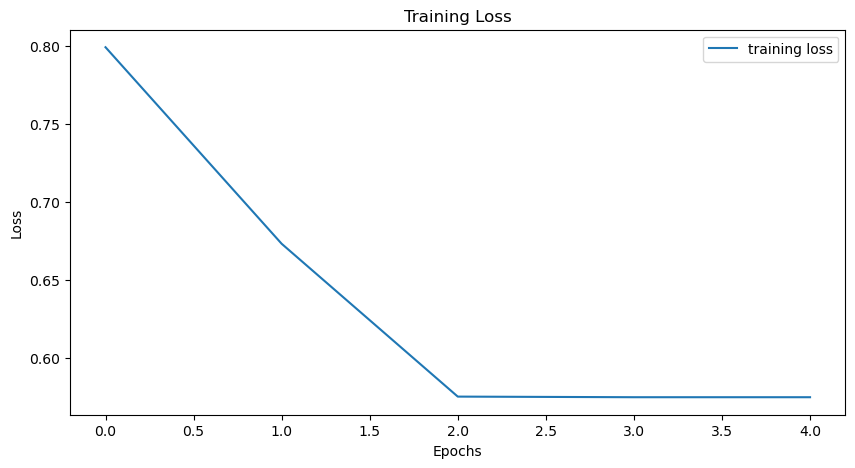

In [33]:
plt.figure(figsize=(10,5))
plt.plot(train_loss,label='training loss')
#plt.plot(test_loss,label='testing loss')
plt.title("Training Loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

In [201]:
#save the model
checkpoint = {
    'epoch': epochs,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
   
}
# Specify the path to save the model to:
#save_path = "/home/jbg/Documents/geofisica_lapaz/modelo_entrenadop"

torch.save(model.state_dict(),"modeloeqtransformers_entrenado.pth")

### Prueba

[[5.78715917e-112 1.22991532e-111 2.61097340e-111 ... 0.00000000e+000
  0.00000000e+000 0.00000000e+000]
 [0.00000000e+000 0.00000000e+000 0.00000000e+000 ... 0.00000000e+000
  0.00000000e+000 0.00000000e+000]
 [1.00000000e+000 1.00000000e+000 1.00000000e+000 ... 1.00000000e+000
  1.00000000e+000 1.00000000e+000]]


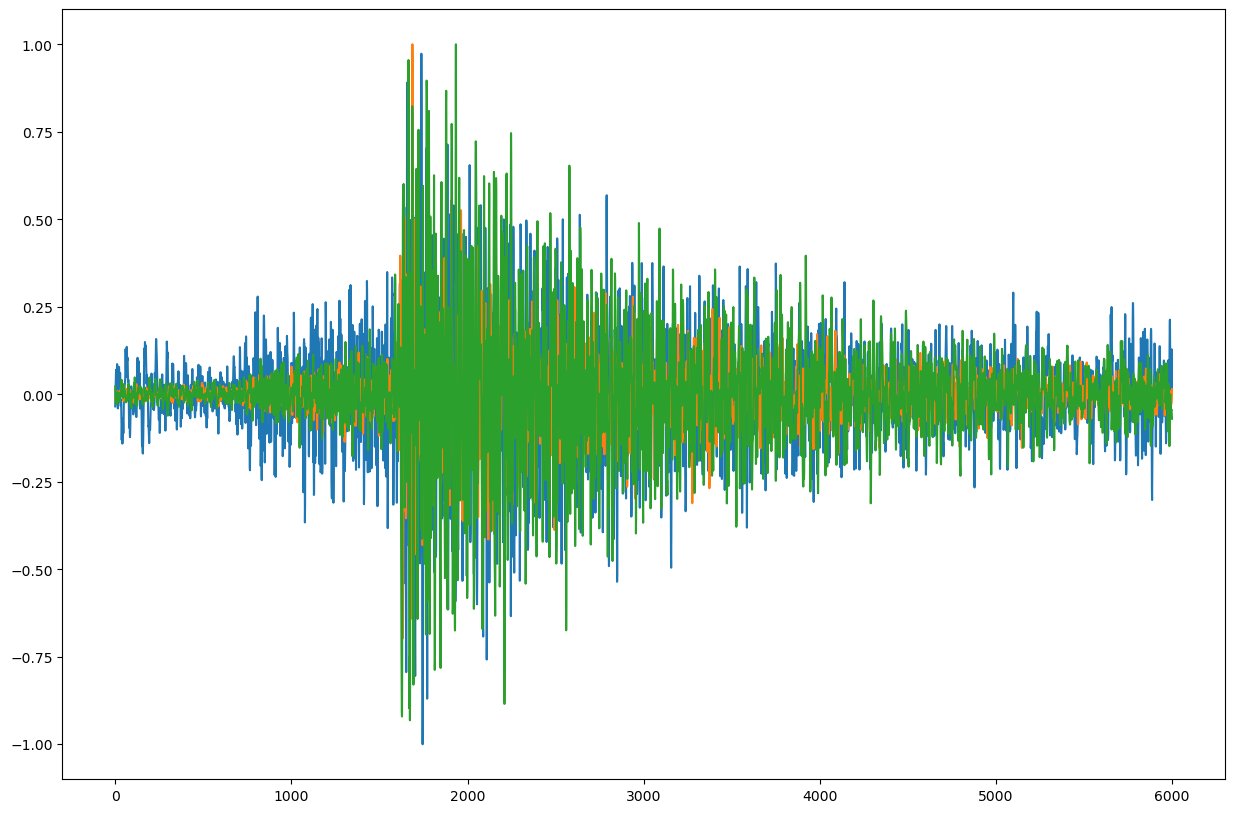

In [40]:
sample = dev_generator[np.random.randint(len(dev_generator))]
fig = plt.figure(figsize=(15, 10))
#axs = fig.plot(1, 1, sharex=True, gridspec_kw={"hspace": 0, "height_ratios": [3, 1, 1]})
plt.plot(sample["X"].T)
print(sample["y"])

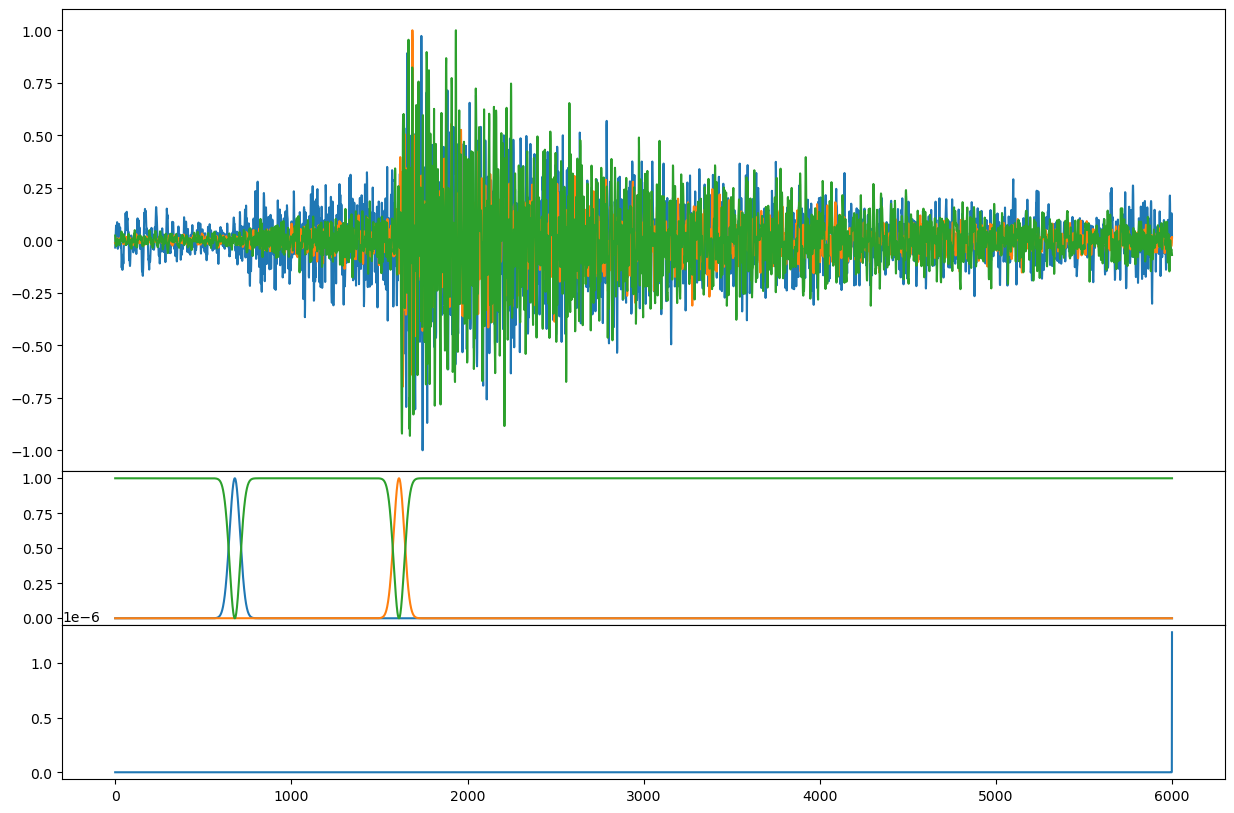

In [41]:
fig = plt.figure(figsize=(15, 10))
axs = fig.subplots(3, 1, sharex=True, gridspec_kw={"hspace": 0, "height_ratios": [3, 1, 1]})
axs[0].plot(sample["X"].T)
axs[1].plot(sample["y"].T)

model.eval()  # close the model for evaluation

with torch.no_grad():
    pred = model(torch.tensor(sample["X"], device=model.device).unsqueeze(0))  # Add a fake batch dimension
    pred = pred[0].cpu().numpy()

axs[2].plot(pred.T)

### Prediccion de todos los eventos

#### Carga del modelo

In [59]:
print(type(full_prob))
print(len(full_prob))

<class 'torch.Tensor'>
1046
